In [1]:
%matplotlib inline
import quantstats as qs
import numpy as np

# extend pandas functionality with metrics, etc.
qs.extend_pandas()

# fetch the daily returns for a stock
stock = pd.Series(np.random.randn(1000))

# show sharpe ratio
qs.stats.sharpe(stock)

np.float64(-0.861367500369864)

TypeError: 'value' must be an instance of str or bytes, not a int

<Figure size 1000x600 with 0 Axes>

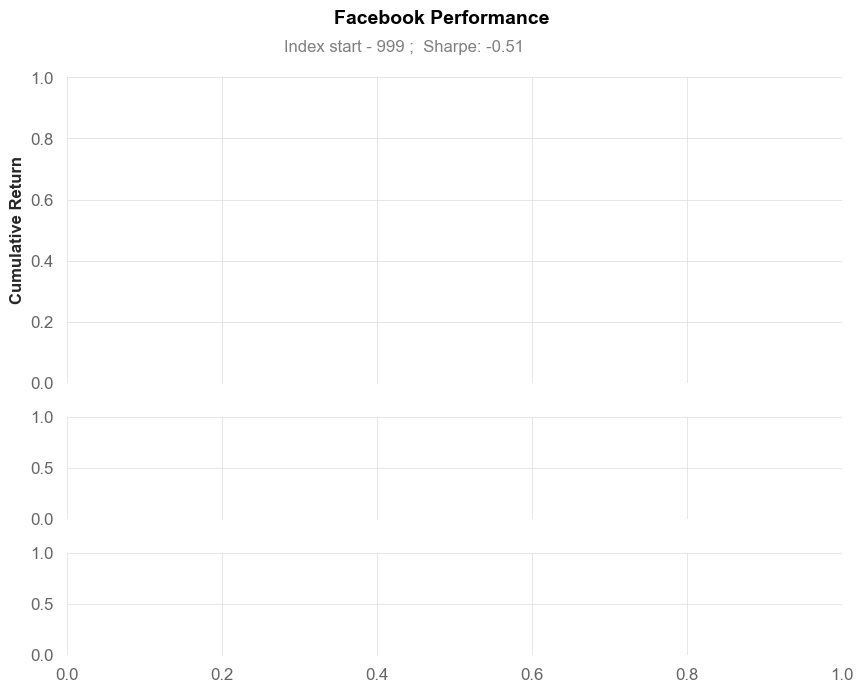

In [2]:
qs.plots.snapshot(stock, title='Facebook Performance', show=True)

In [3]:
import pandas as pd

def calc_rsrs_factor(df: pd.DataFrame, win: int = 18):
    df = df.copy()

    # 计算滑动窗口的协方差 Cov(low, high)
    rolling_cov = df["low"].rolling(window=win).cov(df["high"])

    # 计算滑动窗口的方差 Var(low)
    rolling_var = df["low"].rolling(window=win).var()

    df["RSRS"] = rolling_cov / rolling_var

    return df["RSRS"]

In [4]:
start = "20180101"
end = "20250601"

hs300 = pro.index_daily(ts_code = "000300.SH", start = start, end = end)
hs300.index = pd.to_datetime(hs300["trade_date"])
hs300 = hs300.sort_index(ascending=True)

def calc_rsrs(df: pd.DataFrame, win: int = 18):
    df = df.copy()

    # 计算滑动窗口的协方差 Cov(low, high)
    rolling_cov = df["low"].rolling(window=win).cov(df["high"])

    # 计算滑动窗口的方差 Var(low)
    rolling_var = df["low"].rolling(window=win).var()

    df["rsrs"] = rolling_cov / rolling_var

    return df

def calc_rsrs_zscored(df: pd.DataFrame, n: int = 18, m: int = 600):
    df = calc_rsrs(df, n)
    df["rsrs_"] = df["rsrs"].fillna(0)

    ZSCORE = (df['rsrs_'] - df['rsrs_'].rolling(m).mean()) / df['rsrs_'].rolling(m).std()
    df['rsrs_z'] = ZSCORE
    return df.drop(columns='rsrs_')

rsrs_z = calc_rsrs_zscored(hs300, 18, 600)

回测起始日： 2006-04-05 00:00:00


<Figure size 1000x600 with 0 Axes>

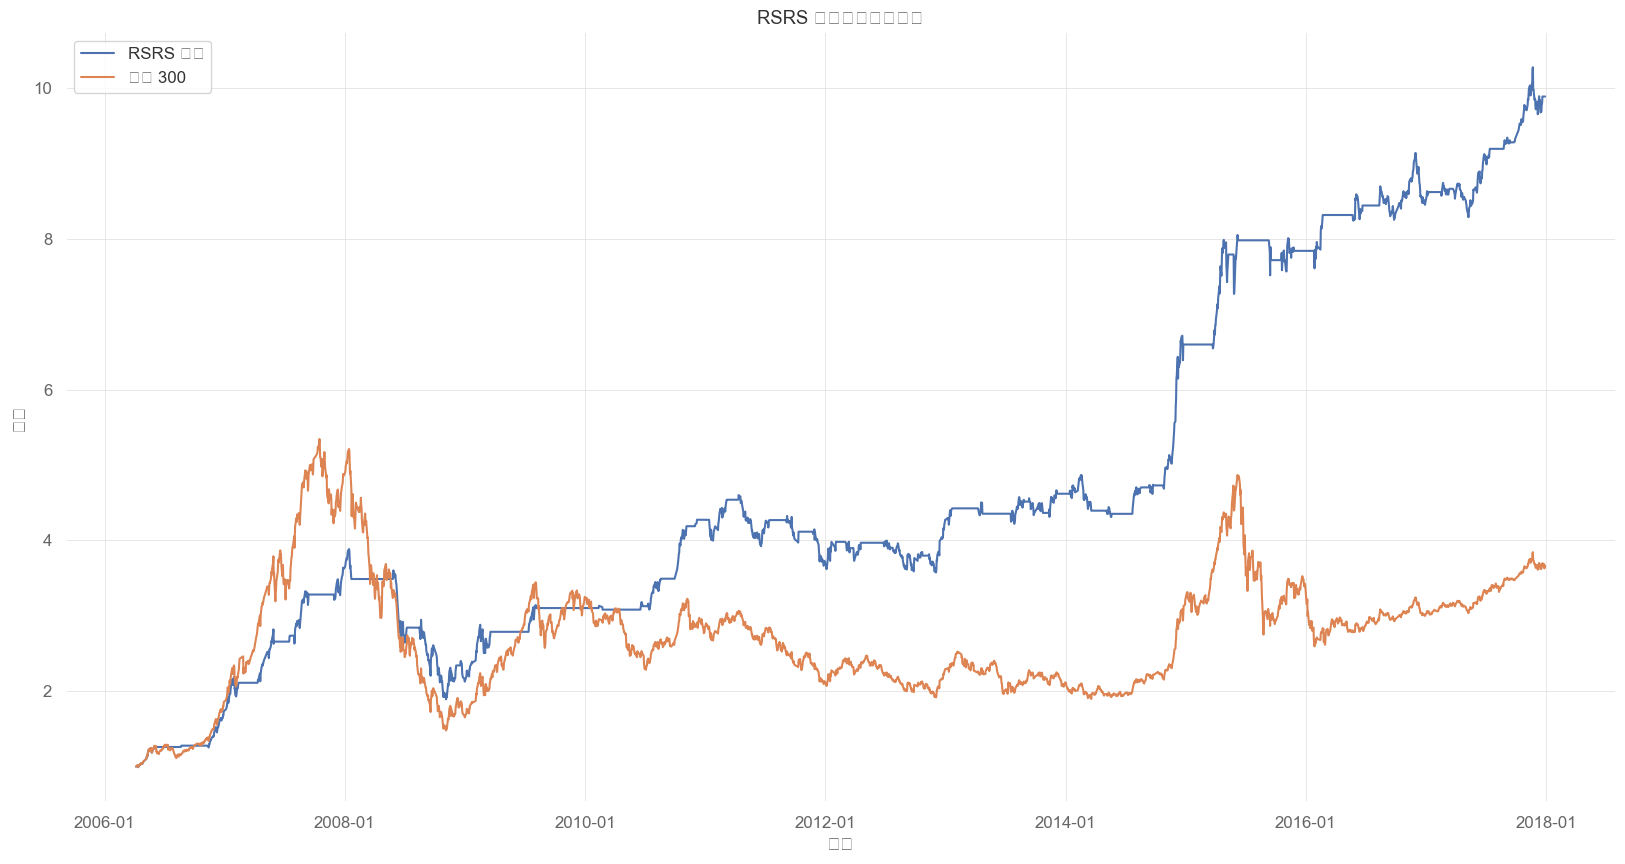

In [5]:
import matplotlib.dates as mdate
def RSRS_Strategy(start: datetime.date, end: datetime.date, n: int=18, m: int=600):
    start_ = start.strftime("%Y%m%d")
    end_ = end.strftime("%Y%m%d")

    data = pro.index_daily(ts_code = "000300.SH", start_date = start_, end_date = end_)
    data.index = pd.to_datetime(data["trade_date"])
    df = data.sort_index(ascending=True)

    rsrs_z = calc_rsrs_zscored(df, n, m)  # 计算标准分指标
    
    # 需要扣除前期计算的 600 日
    rsrs_z=rsrs_z[max(n, m):]
    
    print('回测起始日：',min(rsrs_z.index))

    z_singal = []
    threshold = 0.7
    for row in range(len(rsrs_z)):
        if rsrs_z['rsrs_z'][row] > threshold:
            z_singal.append(1)

        else:
            if row != 0:
                if z_singal[-1] and rsrs_z['rsrs_z'][row] > -threshold:
                    z_singal.append(1)
                else:
                    z_singal.append(0)
            else:
                z_singal.append(0)

    # 交易信号
    rsrs_z['z_singal'] = z_singal
    
    # 每日收益
    rsrs_z['ret'] = rsrs_z['close'].pct_change()

    # 累积净值
    z_cum = (1+rsrs_z['z_singal']*rsrs_z['ret']).cumprod()

    # 基准净值
    benchmark = (1+rsrs_z['ret']).cumprod()

    # 画图
    plt.figure()
    fig = plt.figure(figsize=(20, 10))
    ax1 = fig.add_subplot(1, 1, 1)

    ax1.plot(z_cum, label='RSRS 策略')
    ax1.plot(benchmark, label='沪深 300')

    ax1.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m'))
    plt.legend(loc='best')
    plt.xlabel('时间')
    plt.ylabel('净值')
    plt.title('RSRS 指标策略净值曲线')
    plt.show()

    return z_cum, benchmark
    
strategy, benchmark = RSRS_Strategy(
    datetime.date(2005, 1, 1), datetime.date(2018, 1, 1), m=300
)

In [6]:
import quantstats as qs

                    Benchmark    Strategy
------------------  -----------  ----------
Start Period        2006-04-10   2006-04-10
End Period          2017-12-29   2017-12-29
Risk-Free Rate      0.0%         0.0%
Time in Market      20.0%        47.0%

Cumulative Return   -100.0%      888.46%
CAGR﹪              -100.0%      14.44%

Sharpe              0.03         1.17
Prob. Sharpe Ratio  53.77%       100.0%
Sortino             0.03         1.77
Sortino/√2          0.02         1.25
Omega               1.36         1.36

Max Drawdown        -100.0%      -51.26%
Longest DD Days     3727         1004

Gain/Pain Ratio     0.02         0.36
Gain/Pain (1M)      0.06         1.68

Payoff Ratio        0.91         0.91
Profit Factor       1.02         1.36
Common Sense Ratio  1.67         1.89
CPC Index           0.56         0.68
Tail Ratio          1.64         1.39
Outlier Win Ratio   18.15        8.84
Outlier Loss Ratio  1.66         3.51

MTD                 0.0%         1.54%
3M         

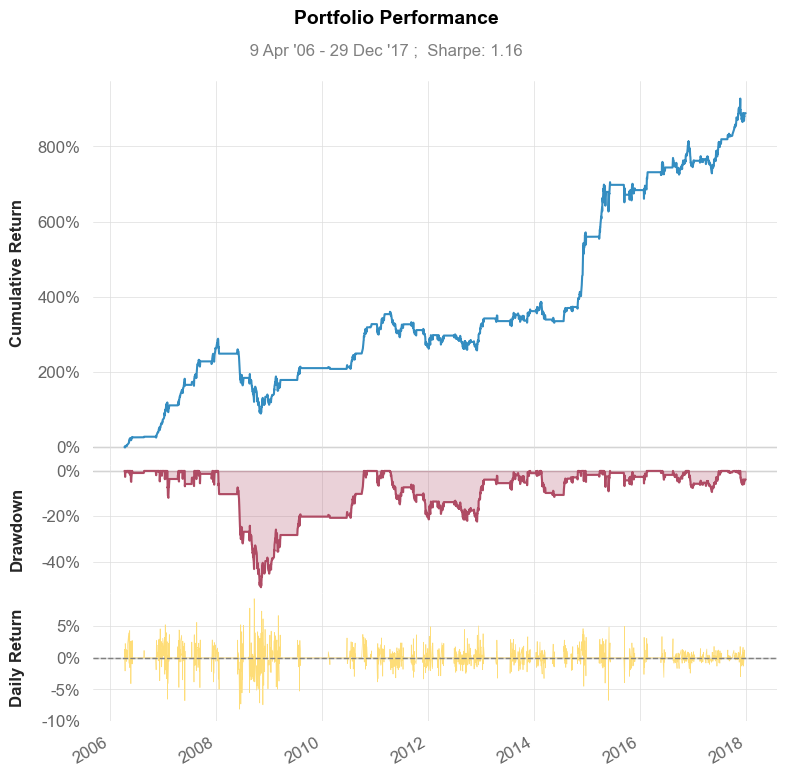

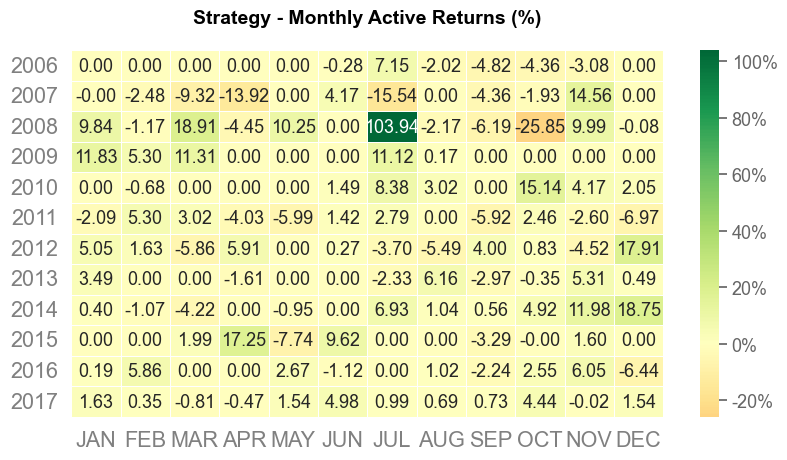

In [7]:
qs.reports.basic(strategy, benchmark, output="/tmp/report.html")